# Common Constants

In [1]:
from run_battery import BatteryRunner, BatteryConfigs

runner = BatteryRunner.of(BatteryConfigs.Bugs2Fix)

In [2]:
runner.load_cases()

Loaded 100 cases!


In [3]:
from model_wrapper import ModelFamily

# Generate Output

In [4]:
#runner.run_battery(
#    family=ModelFamily.CodeGen1.multi
#)

In [5]:
runner.case_count = 2
runner.load_cases()

Loaded 2 cases!


# Interpret Output

In [5]:
import metric
runner.init_render(family=ModelFamily.CodeGen1.multi)

## Metric: Accuracy (Exact Match)

Saved figure to ./figs/b2f-1.png


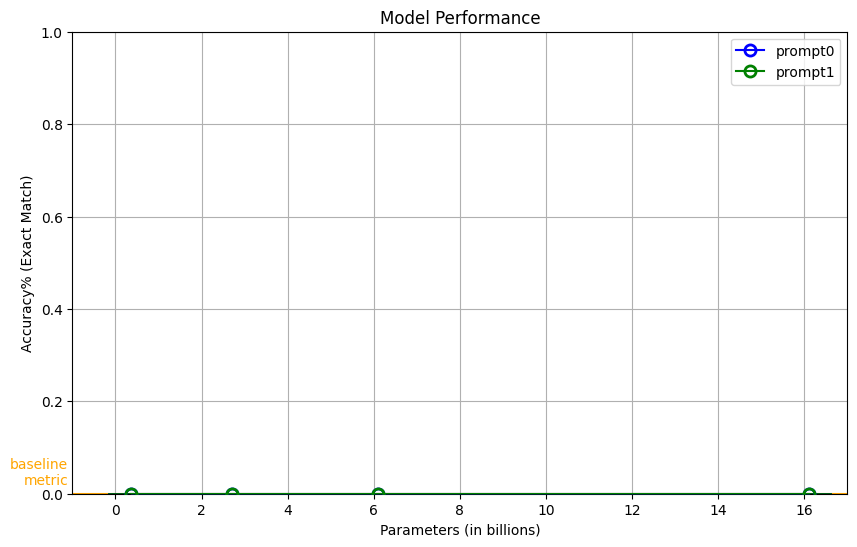

{'prompt0': [[0.0], [0.0], [0.0], [0.0]],
 'prompt1': [[0.0], [0.0], [0.0], [0.0]]}

In [6]:
runner.render_metric(metric.ExactMatch, save="./figs/b2f-1.png")

## Metric: BLEU

Saved figure to ./figs/b2f-2.png


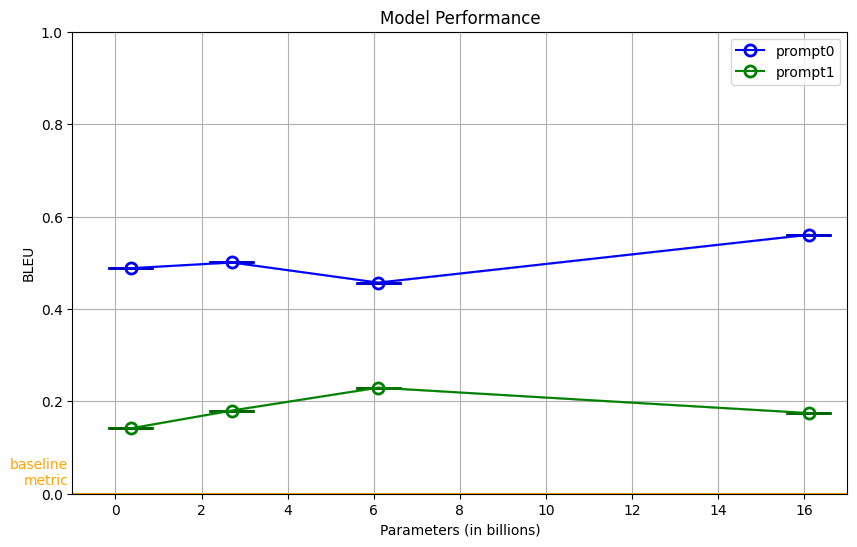

{'prompt0': [[0.48820137569847905],
  [0.5006341113747632],
  [0.45705067969834523],
  [0.5606953700959482]],
 'prompt1': [[0.14156945771243312],
  [0.18010279725351888],
  [0.22966604098260265],
  [0.17465742390969388]]}

In [7]:
runner.render_metric(metric.BLEU, save="./figs/b2f-2.png")

## Metric: CodeBLEU

/usr/local/lib/python3.8/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


Saved figure to ./figs/b2f-3.png


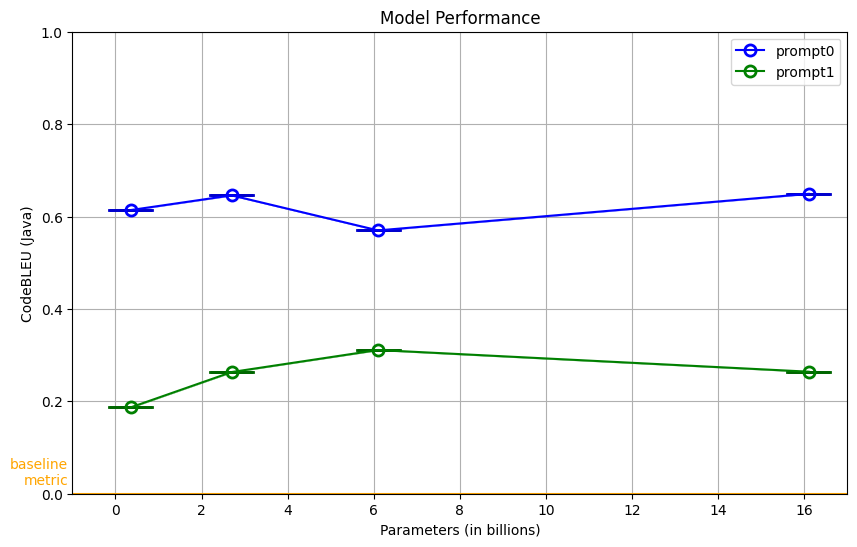

{'prompt0': [[0.6139429235670194],
  [0.6458269714813404],
  [0.5699422358685238],
  [0.6491634904813729]],
 'prompt1': [[0.18673316631750742],
  [0.2634117729357921],
  [0.31108544782004577],
  [0.26415028332874624]]}

In [8]:
runner.render_metric(metric.CodeBLEUJava, save="./figs/b2f-3.png")